In [1]:
from netCDF4 import Dataset
import os

import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata


import matplotlib.tri as tri

## Merging Turbidity data from BAWs Untrim data set with Johannes' SCHISM grid



### BAW data

In [2]:
baw = Dataset('/scratch/local1/spm/f.IZHel_u09_024_val2_netcdf.2D.cut.nc', 'r')

In [3]:
# print all variables inclunding "time" in name
_ = [print(baw.variables[item]) for item in baw.variables.keys() if 'time' in item]

<class 'netCDF4._netCDF4.Variable'>
float64 nMesh2_time(nMesh2_time)
    long_name: time
    units: seconds since 2019-11-05 10:06:04.034000000 01:00
    name_id: 1640
    axis: T
    bounds: nMesh2_time_bnd
    standard_name: time
unlimited dimensions: 
current shape = (1,)
filling off
<class 'netCDF4._netCDF4.Variable'>
float64 nMesh2_time_bnd(nMesh2_time, two)
unlimited dimensions: 
current shape = (1, 2)
filling off
<class 'netCDF4._netCDF4.Variable'>
float64 nMesh2_data_time(nMesh2_data_time)
    long_name: time
    units: hours since 2016-01-01 07:40:00 01:00
    name_id: 1640
    axis: T
    standard_name: time
unlimited dimensions: nMesh2_data_time
current shape = (17551,)
filling off
<class 'netCDF4._netCDF4.Variable'>
float64 dmqs_sim_time_step()
    long_name: Rechenzeitschritt der urspruenglichen Simulation
    units: s
    _FillValue: 1e+31
    cf_role: dmqs_sim_time_step
unlimited dimensions: 
current shape = ()
filling off


In [4]:
from datetime import datetime, timedelta, timezone

# Example array of hours since 2016-01-01 07:40:00 +01:00

# Base time for the calculation
base_time_hours = datetime(2016, 1, 1, 7, 40, 0, tzinfo=timezone(timedelta(hours=1)))

# Function to convert hours to datetime object
def convert_hours_to_datetime(hours):
    return base_time_hours + timedelta(hours=hours)

# Convert the example hours
baw_time = [convert_hours_to_datetime(hours) for hours in baw.variables['nMesh2_data_time'][:]]


In [5]:
# get the index of the first time step in each month
def first_time_step_each_month(datetimes):
    indices = []
    last_month = None
    for i, dt in enumerate(datetimes):
        if dt.month != last_month:
            indices.append(i)
            last_month = dt.month
    return indices

idx_of_month = first_time_step_each_month(baw_time)

In [6]:
baw_face_x = baw.variables['Mesh2_face_x'][:]
baw_face_y = baw.variables['Mesh2_face_y'][:]

baw_spm = baw.variables['Mesh2_face_Schwebstoffgehalt_2d']
baw_spm.shape

(17551, 6, 1, 96160)

In [6]:
# # slice the data into months
# n_months = len(idx_of_month)
# baw_spm_slices = np.empty((n_months, baw_spm.shape[1], baw_spm.shape[3]))
                          
# for ii in range(n_months):
#     print(ii,n_months)
#     if ii == n_months-1:
#         baw_spm_slices[ii] = np.nanmean(baw_spm[idx_of_month[ii]:,:,0,:],axis=0)
#     else:
#         baw_spm_slices[ii] = np.nanmean(baw_spm[idx_of_month[ii]:idx_of_month[ii+1],:,0,:],axis=0)

# # pickle baw_spm_slices
# import pickle
# with open('/home/zmaw/u301513/Documents/scr/phd/bicest/oceantracker/experiments/auxiliaries/adding_baw_turbidity_to_hzg_dataset/baw_spm_slices.pickle', 'wb') as f:
#     pickle.dump(baw_spm_slices, f)


0 12
1 12
2 12
3 12
4 12
5 12
6 12
7 12
8 12
9 12
10 12
11 12


In [7]:
# read baw_spm_slices pickle
import pickle
with open('/home/zmaw/u301513/Documents/scr/phd/bicest/oceantracker/experiments/auxiliaries/adding_baw_turbidity_to_hzg_dataset/baw_spm_slices.pickle', 'rb') as f:
    baw_spm_slices = pickle.load(f)

In [8]:
# [print(''.join([byte.decode('utf-8') for byte in baw.variables['Mesh2_Schwebstoffklassen_2d'][ii].data])) for ii in range(6)]
classes = ['sum_of_all_classes','very_fine_silt','fine_silt','medium_silt','coarse_silt','very_fine_sand']
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

spm = {}
for ii in range(6):
    spm[classes[ii]] = {}
    for jj in range(len(months)):
        spm[classes[ii]][months[jj]] = baw_spm_slices[jj,ii,:]

In [10]:
# for month in months:
#     plt.figure()
#     plt.scatter(baw_face_x,baw_face_y,c=spm['sum_of_all_classes'][month],s=1,vmin=0,vmax=0.4)
#     plt.colorbar()


### HZG data

In [9]:
hzg = Dataset('/scratch/local1/output/22_11_01_depth_losses_v10/22_11_01_depth_losses_v10_grid.nc', 'r')

In [10]:
_ = [print(item) for item in hzg.variables.keys()]

x
triangles
triangle_area
adjacency
node_type
is_boundary_triangle
water_depth


In [11]:

hzg_node_x = hzg.variables['x'][:,0]
hzg_node_y = hzg.variables['x'][:,1]

hzg_tri = hzg.variables['triangles'][:]
hzg_tri

masked_array(
  data=[[   10,     0,     7],
        [    1,     0,     9],
        [   10,     9,     0],
        ...,
        [32426, 32427, 32430],
        [32429, 32428, 32431],
        [32430, 32431, 32428]],
  mask=False,
  fill_value=999999,
  dtype=int32)

## Testing alternative interpolation schemes

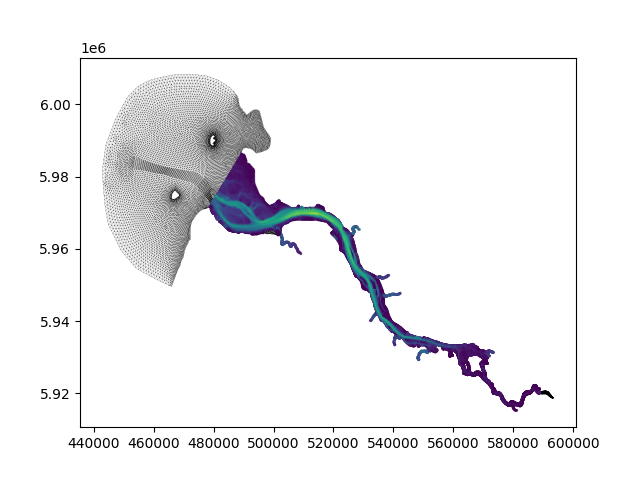

In [14]:
%matplotlib widget
# plot hzg tri plot
plt.figure()
plt.triplot(hzg_node_x, hzg_node_y, hzg_tri, c='k', linewidth=0.1)
# baw
plt.scatter(baw_face_x, baw_face_y, s=1, c=spm['sum_of_all_classes']['Jan'],alpha=0.5)
plt.show()

In [15]:
source_points = np.array([baw_face_x, baw_face_y]).T

# Create target grid points from hzg data
target_points = np.array([hzg_node_x, hzg_node_y]).T

source_data = spm['sum_of_all_classes']['Jan']
# source_data = np.nanmean(source_data, axis=0)

# Interpolate baw data onto hzg grid
interpolated_spm = griddata(source_points, source_data, target_points, method='linear')
# Note: The 'method' argument can be 'linear', 'nearest', or 'cubic'.

# set 0- where nan
# interpolated_spm[np.isnan(interpolated_spm)] = 0
# take nearest neighbour to fill nan values
interpolated_spm[np.isnan(interpolated_spm)] = griddata(source_points, source_data, target_points[np.isnan(interpolated_spm)], method='nearest')
# all that remain nan are outside the domain and set to zero
interpolated_spm[np.isnan(interpolated_spm)] = 0

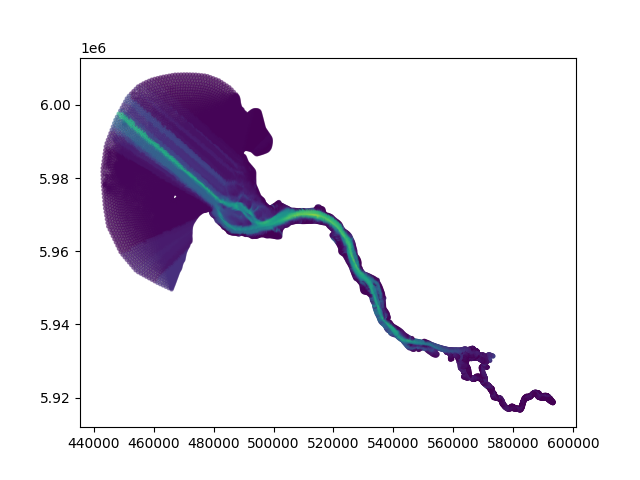

In [16]:
%matplotlib widget
# plot hzg tri plot
plt.figure()
plt.triplot(hzg_node_x, hzg_node_y, hzg_tri, c='k', linewidth=0.1)
# baw
plt.scatter(hzg_node_x, hzg_node_y, s=5, c=interpolated_spm,alpha=0.5)
plt.show()

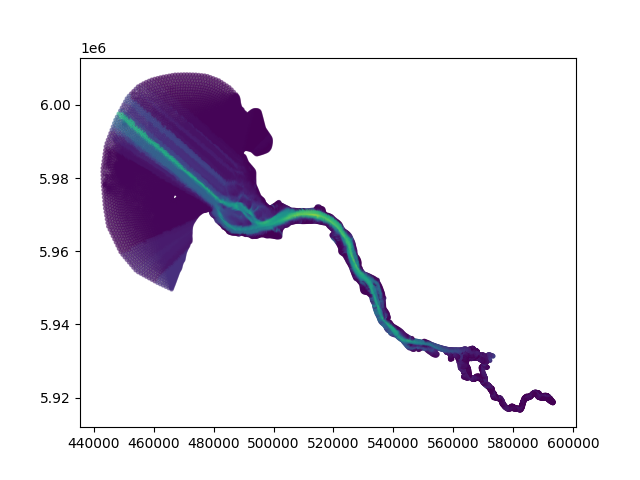

In [17]:
%matplotlib widget
# plot hzg tri plot
plt.figure()
plt.triplot(hzg_node_x, hzg_node_y, hzg_tri, c='k', linewidth=0.1)
# baw
plt.scatter(hzg_node_x, hzg_node_y, s=5, c=interpolated_spm,alpha=0.5)
plt.show()

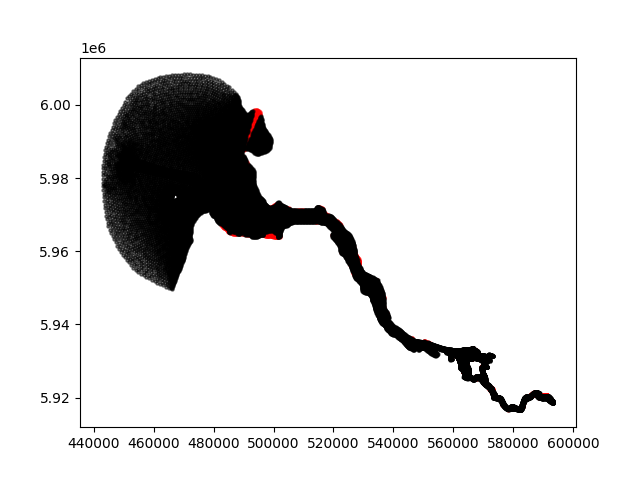

In [18]:
%matplotlib widget
# plot hzg tri plot
plt.figure()
plt.triplot(hzg_node_x, hzg_node_y, hzg_tri, c='k', linewidth=0.1)
# plot the interpolated points that are zero in red the others in black
plt.scatter(hzg_node_x[interpolated_spm==0], hzg_node_y[interpolated_spm==0], s=5, c='r',alpha=0.5)
plt.scatter(hzg_node_x[interpolated_spm!=0], hzg_node_y[interpolated_spm!=0], s=5, c='k',alpha=0.5)



# plt.scatter(baw_face_x, baw_face_y, s=10, c=spm['sum_of_all_classes'][-1,:],alpha=0.5)
plt.show()

## Creating a copy of the HZG dataset with the interpolated SPM values

Created a copy manually with rsync

### Interpolating and merging BAW data onto HZG grid

#### griddata interpolation

In [12]:
path_to_hzg4 = '/scratch/local1/hzg4'

files_in_dir = os.listdir(path_to_hzg4)
files_in_dir[0]

'schout_272.nc'

In [13]:
path_to_dir2 = '/scratch/local1/hzg4'

hzg_df = Dataset(os.path.join(path_to_hzg4,files_in_dir[0]), 'r')

hzg_node_x = hzg_df.variables['SCHISM_hgrid_node_x'][:]
hzg_node_y = hzg_df.variables['SCHISM_hgrid_node_y'][:]

hzg_tri = hzg_df.variables['SCHISM_hgrid_face_nodes'][:,:3] - 1
hzg_tri 

hzg_df.close()

source_points = np.array([baw_face_x, baw_face_y]).T
# Create target grid points from hzg data
target_points = np.array([hzg_node_x, hzg_node_y]).T

for root, dirs, files in os.walk(path_to_dir2):
    n_files = len(files)
    
    for ii,momo in enumerate(sorted(files)):

        # start at ii > 12
        if ii == 12:

            if momo.endswith('.nc'):
                print(momo, f'( {ii} / {n_files} )')
                with Dataset(os.path.join(root, momo), 'a') as ds:

                    for fraction in spm.keys():
                        print(fraction)

                        # read time variable from hzg file
                        hzg_time = ds.variables['time'][0]
                        # to datetime
                        hzg_time = datetime.fromtimestamp(int(hzg_time))
                        # get the month
                        hzg_month = hzg_time.month
                    
                        print(f'Current month: {months[hzg_month-1]}')

                        source_data = spm[fraction][months[hzg_month-1]]

                        # Interpolate baw data onto hzg grid
                        interpolated_spm = griddata(source_points, source_data, target_points, method='linear')
                        # take nearest neighbour to fill nan values
                        interpolated_spm[np.isnan(interpolated_spm)] = griddata(source_points, source_data, target_points[np.isnan(interpolated_spm)], method='nearest')
                        # all that remain nan are outside the domain and set to zero
                        interpolated_spm[np.isnan(interpolated_spm)] = 0


                        # write to files

                        # Create the turbidity variable
                        try:
                            spm_var = ds.createVariable(f'spm_{fraction}', 'f4', ('nSCHISM_hgrid_node',))
                        except:
                            print("NetCDF: String match to name in use: (variable 'spm_sum_of_all_classes', group '/')")
                        # get the variable
                        spm_var = ds.variables[f'spm_{fraction}']
                        # Assign the turbidity data to the variable
                        spm_var[:] = interpolated_spm

                        # If needed, set attributes for the turbidity variable
                        spm_var.units = 'kg/l'  # Adjust this as necessary
                        spm_var.long_name = f'Suspended sediment concentration of {fraction}'
                        # add description
                        spm_var.description = 'Suspended sediment concentration based on BAWs UnTrim model using the Dietrich model received from Arne Hammrich. Average of 3D data over time and depth'




schout_11.nc ( 12 / 365 )


OSError: [Errno -101] NetCDF: HDF error: '/scratch/local1/hzg4/schout_11.nc'

In [15]:
!rm '/scratch/local1/hzg4/schout_11.nc'

In [39]:
test_df = Dataset('/scratch/local1/hzg4/schout_11.nc')

OSError: [Errno -101] NetCDF: HDF error: '/scratch/local1/hzg4/schout_11.nc'

```python

for fraction in spm.keys():
    print(fraction)

    # Create source points from baw data
    source_points = np.array([baw_face_x, baw_face_y]).T

    # Create target grid points from hzg data
    target_points = np.array([hzg_node_x, hzg_node_y]).T

    source_data = spm[fraction]
    source_data = np.mean(source_data, axis=0)

    # Interpolate baw data onto hzg grid
    interpolated_spm = griddata(source_points, source_data, target_points, method='linear')
    # Note: The 'method' argument can be 'linear', 'nearest', or 'cubic'.

    # set 0- where nan
    interpolated_spm[np.isnan(interpolated_spm)] = 0
   

    path_to_dir2 = '/scratch/local1/hzg2'

    for root, dirs, files in os.walk(path_to_dir2):
        n_files = len(files)
        for ii,momo in enumerate(sorted(files)):
            if momo.endswith('.nc'):
                print(momo, f'( {ii+1} / {n_files} )')
                with Dataset(os.path.join(root, momo), 'a') as ds:
                    # Ensure the dimension exists
                    if 'nSCHISM_hgrid_node' not in ds.dimensions:
                        raise ValueError("The dimension 'nSCHISM_hgrid_node' does not exist in the file.")

                    # if not, create it
                    if f'spm_{fraction}' not in ds.variables:
                        spm_var = ds.createVariable(f'spm_{fraction}', 'f4', ('nSCHISM_hgrid_node',))

                    # get the variable
                    spm_var = ds.variables[f'spm_{fraction}']

                    # Assign the turbidity data to the variable
                    spm_var[:] = interpolated_spm

                    # If needed, set attributes for the turbidity variable
                    spm_var.units = 'kg/l'  # Adjust this as necessary
                    spm_var.long_name = f'Suspended sediment concentration of {fraction}'
                    # add description
                    spm_var.description = 'Suspended sediment concentration based on BAWs UnTrim model using the Dietrich model received from Arne Hammrich. Average of 3D data over time and depth'


```

In [15]:
df = Dataset('/scratch/local1/hzg2/schout_1.nc')
# print all variables with spm in name
_ = [print(item) for item in df.variables.keys() if 'spm' in item]
df.close()

spm_sum_of_all_classes
spm_very_fine_silt
spm_fine_silt
spm_medium_silt
spm_coarse_silt
spm_very_fine_sand


In [16]:
df = Dataset('/scratch/local1/hzg2/schout_1.nc')
# print all variables with spm in name
print(df.variables['spm_sum_of_all_classes'][:].shape)
df.close()

(32432,)
